In [95]:
num_clients = 1
distribution_type = 'non_iid'  
root_percentage = 0.1  
root_client = True


# Split into Dist

In [96]:
import os
import struct
import numpy as np
from sklearn.model_selection import train_test_split

def LoadMNIST(path, kind='train'):
    labels_path = os.path.join(path, f'{kind}-labels.idx1-ubyte')
    images_path = os.path.join(path, f'{kind}-images.idx3-ubyte')

    with open(labels_path, 'rb') as lbpath:
        struct.unpack('>II', lbpath.read(8))  # Unused magic number and count
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        struct.unpack('>IIII', imgpath.read(16))  # Unused magic number and dimensions
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)

    return images, labels

mnist_path = 'mnist'
x_train, y_train = LoadMNIST(mnist_path, kind='train')
x_test, y_test = LoadMNIST(mnist_path, kind='t10k')
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=10000, random_state=42)
x_train = x_train.reshape(-1, 28, 28, 1)
x_valid = x_valid.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

print("Training data:", x_train.shape, y_train.shape)
print("Validation data:", x_valid.shape, y_valid.shape)
print("Test data:", x_test.shape, y_test.shape)


Training data: (50000, 28, 28, 1) (50000,)
Validation data: (10000, 28, 28, 1) (10000,)
Test data: (10000, 28, 28, 1) (10000,)


Root Data samples
[ 8 29 30 20 23  5  0  0 25 40]
Root Client assigned: 98


/var/folders/k8/v02rcpmj2bv13wz_w7qm_tdh0000gn/T/ipykernel_29726/1722090128.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10')
/var/folders/k8/v02rcpmj2bv13wz_w7qm_tdh0000gn/T/ipykernel_29726/1722090128.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10')


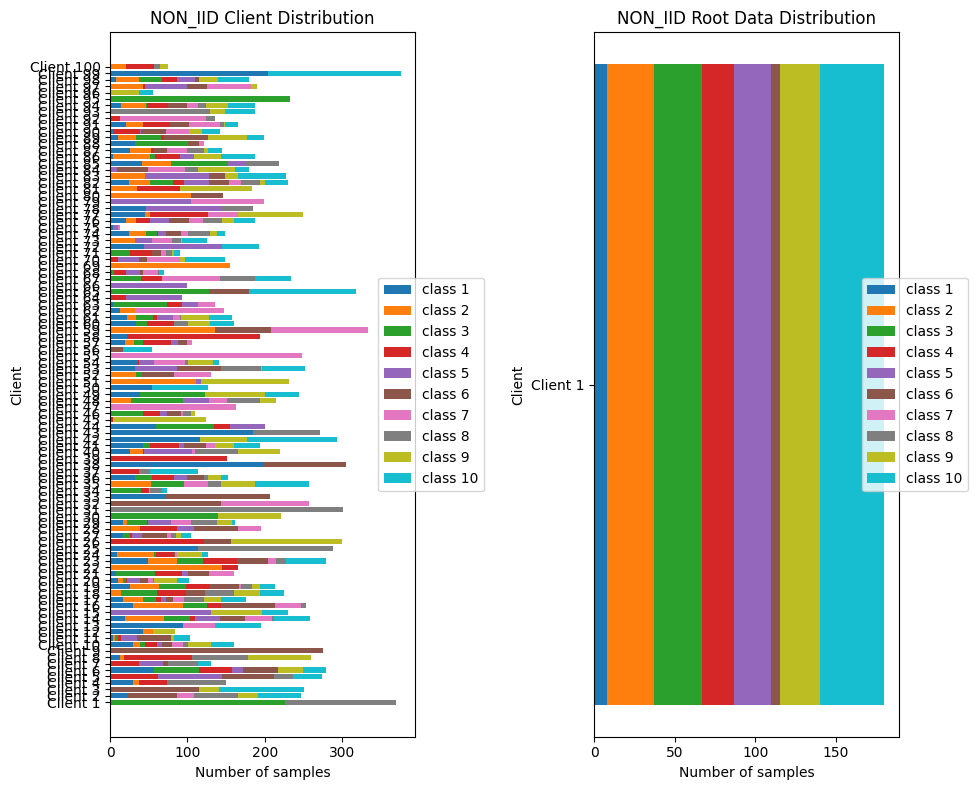

Root Data: 10 samples
[ 8 29 30 20 23  5  0  0 25 40]


In [99]:
import os
import numpy as np
import random

class FederatedDataSplitter:
    def __init__(self, x_train, y_train, x_test, y_test, num_clients=10, distribution='iid', dataset_dir='dataset', root_client=False, root_percentage=0.1):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.num_clients = num_clients
        self.distribution = distribution
        self.dataset_dir = dataset_dir
        self.root_client = root_client
        self.client_distributions = []
        self.root_distribution = []
        self.root_percentage = root_percentage

    def SplitData(self):
        os.makedirs(self.dataset_dir, exist_ok=True)
        client_data = []

        if self.distribution == 'iid':
            self.IIDSplit(client_data)
        else:
            self.NonIIDSplit(client_data)

        if self.root_client:
            self.AssignRootData(client_data)
        else:
            self.AssignRootDataAsSubset()

        self.SaveTestData()

    def IIDSplit(self, client_data):
        x_train_clients = self.x_train
        y_train_clients = self.y_train
        split_sizes = [len(x_train_clients) // self.num_clients] * self.num_clients
        if sum(split_sizes) != len(x_train_clients):
            split_sizes[-1] += len(x_train_clients) - sum(split_sizes)

        start_idx = 0
        for i in range(self.num_clients):
            end_idx = start_idx + split_sizes[i]
            x_client = x_train_clients[start_idx:end_idx]
            y_client = y_train_clients[start_idx:end_idx]
            start_idx = end_idx

            client_data.append((x_client, y_client))
            self.SaveClientData(x_client, y_client, client_id=i + 1)
            self.client_distributions.append(np.bincount(y_client, minlength=10))

    def NonIIDSplit(self, client_data):
        total_samples = len(self.x_train)
        indices = np.arange(total_samples)
        np.random.shuffle(indices)
        classes = np.unique(self.y_train)

        for i in range(self.num_clients):
            num_samples = random.randint(total_samples // (self.num_clients * 2), total_samples // self.num_clients)
            x_client, y_client = [], []
            selected_classes = np.random.choice(classes, size=random.randint(1, len(classes)), replace=False)

            for cls in selected_classes:
                class_indices = indices[self.y_train[indices] == cls]
                num_class_samples = random.randint(1, num_samples // len(selected_classes))
                chosen_indices = np.random.choice(class_indices, size=min(num_class_samples, len(class_indices)), replace=False)
                x_client.extend(self.x_train[chosen_indices])
                y_client.extend(self.y_train[chosen_indices])

            client_data.append((np.array(x_client), np.array(y_client)))
            self.SaveClientData(np.array(x_client), np.array(y_client), client_id=i + 1)
            self.client_distributions.append(np.bincount(y_client, minlength=10))

    def AssignRootDataAsSubset(self):
        total_samples = int(len(self.x_train) * self.root_percentage)
        indices = np.random.choice(len(self.x_train), size=total_samples, replace=False)
        x_root = self.x_train[indices]
        y_root = self.y_train[indices]
        self.SaveRootData(x_root, y_root)
        self.root_distribution = np.bincount(y_root, minlength=10)

    def AssignRootData(self, client_data):
        random_client_id = np.random.randint(0, self.num_clients)
        x_root, y_root = client_data[random_client_id]
        self.SaveRootData(x_root, y_root)
        self.root_distribution = np.bincount(y_root, minlength=10)
        print(f'Root Client assigned: {random_client_id + 1}')

    def SaveClientData(self, x_client, y_client, client_id):
        client_dir = os.path.join(self.dataset_dir, f'client_{client_id}')
        os.makedirs(client_dir, exist_ok=True)
        np.save(os.path.join(client_dir, 'x_data.npy'), x_client)
        np.save(os.path.join(client_dir, 'y_data.npy'), y_client)

    def SaveTestData(self):
        test_dir = os.path.join(self.dataset_dir, 'test')
        os.makedirs(test_dir, exist_ok=True)
        np.save(os.path.join(test_dir, 'x_test.npy'), self.x_test)
        np.save(os.path.join(test_dir, 'y_test.npy'), self.y_test)

    def SaveRootData(self, x_root, y_root):
        root_dir = os.path.join(self.dataset_dir, 'root')
        os.makedirs(root_dir, exist_ok=True)
        np.save(os.path.join(root_dir, 'x_data.npy'), x_root)
        np.save(os.path.join(root_dir, 'y_data.npy'), y_root)
        print(f'Root Data samples')
        print(np.bincount(y_root, minlength=10))


    @staticmethod
    def PlotDistributions(client_dist, root_dist, num_clients, title, root_client=False, root_assigned_client=None):
        plt.figure(figsize=(10, 8))
        plt.subplot(1, 2, 1)
        FederatedDataSplitter.PlotSampleStats(client_dist, num_clients, root_client=root_client, root_assigned_client=root_assigned_client)
        plt.title(f'{title} Client Distribution')
        if not root_client:
            plt.subplot(1, 2, 2)
            FederatedDataSplitter.PlotSampleStats([root_dist], 1)
            plt.title(f'{title} Root Data Distribution')
        plt.tight_layout()
        plt.show()

    @staticmethod
    def PlotSampleStats(dist, num_clients, root_client=False, root_assigned_client=None):
        colors = plt.cm.get_cmap('tab10')
        if num_clients == 1:
            classes = [f'class {i + 1}' for i in range(len(dist[0]))]
            left = 0
            for i in range(len(classes)):
                plt.barh(0, dist[0][i], left=left, color=colors(i), label=classes[i])
                left += dist[0][i]
        else:
            classes = [f'class {i + 1}' for i in range(len(dist[0]))]
            left = np.zeros(num_clients)
            for i in range(len(classes)):
                plt.barh(range(num_clients), [dist[j][i] for j in range(num_clients)],
                         left=left, color=colors(i), label=classes[i])
                left += [dist[j][i] for j in range(num_clients)]
            if root_client and root_assigned_client is not None:
                plt.barh(root_assigned_client - 1, sum(dist[root_assigned_client - 1]), color='red', alpha=0.3, label="Root Client")
        plt.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))
        plt.yticks(range(num_clients), [f'Client {i + 1}' for i in range(num_clients)])
        plt.xlabel('Number of samples')
        plt.ylabel('Client')


splitter = FederatedDataSplitter(x_train, y_train, x_test, y_test,
                                  num_clients=num_clients, 
                                  dataset_dir='dataset',
                                  distribution=distribution_type,
                                  root_client=root_client,
                                  root_percentage=root_percentage)

splitter.SplitData()
splitter.PlotDistributions(splitter.client_distributions, splitter.root_distribution, splitter.num_clients, splitter.distribution.upper())
#Print number of samples and number of samples per class in root data
print(f'Root Data: {len(splitter.root_distribution)} samples')
print(splitter.root_distribution)



# CIFAR

/var/folders/k8/v02rcpmj2bv13wz_w7qm_tdh0000gn/T/ipykernel_15875/294792477.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10')
/var/folders/k8/v02rcpmj2bv13wz_w7qm_tdh0000gn/T/ipykernel_15875/294792477.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10')


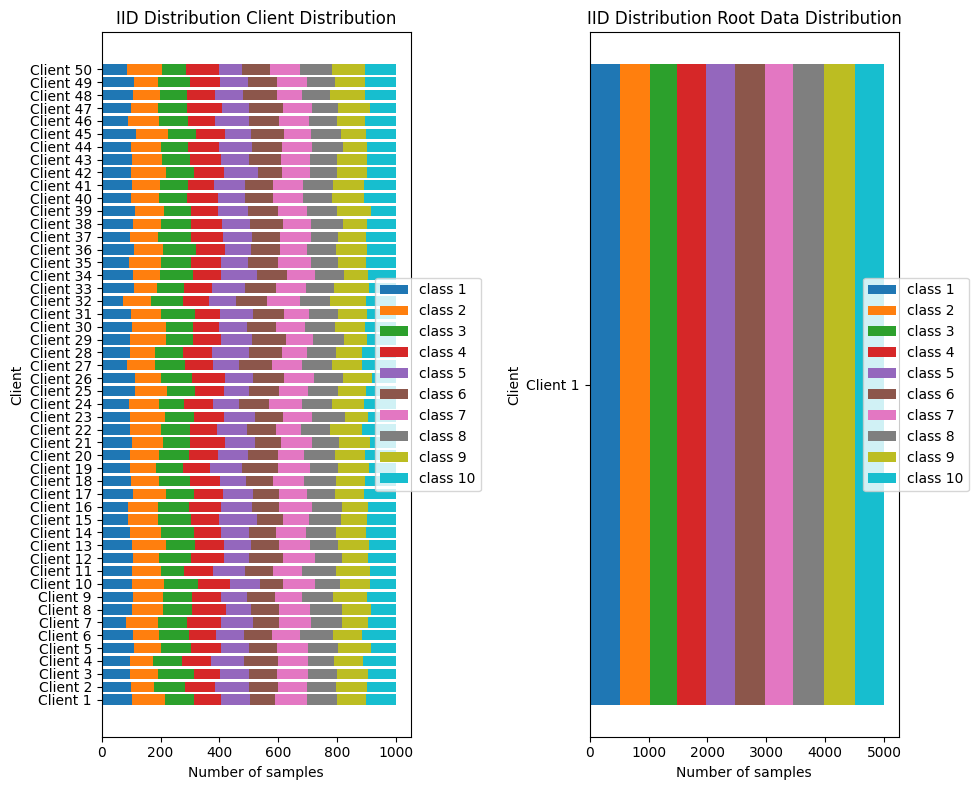

In [25]:
@staticmethod
def PlotDistributions(client_dist, root_dist, num_clients, title, root_client=False, root_assigned_client=None):
    plt.figure(figsize=(10, 8))
    
    # Plot Client Distribution
    plt.subplot(1, 2, 1)
    FederatedDataSplitter.PlotSampleStats(client_dist, num_clients, root_client=root_client, root_assigned_client=root_assigned_client)
    plt.title(f'{title} Client Distribution')
    
    # Plot Root Data Distribution (only if root_client is False)
    if not root_client:
        plt.subplot(1, 2, 2)
        FederatedDataSplitter.PlotSampleStats([root_dist], 1)  # Pass root distribution as a single row matrix
        plt.title(f'{title} Root Data Distribution')
    
    plt.tight_layout()
    plt.show()

@staticmethod
def PlotSampleStats(dist, num_clients, root_client=False, root_assigned_client=None):
    colors = plt.cm.get_cmap('tab10')
    
    # If num_clients is 1, plot a single horizontal bar for the root dataset
    if num_clients == 1:
        classes = [f'class {i + 1}' for i in range(len(dist[0]))]
        left = 0
        for i in range(len(classes)):
            plt.barh(0, dist[0][i], left=left, color=colors(i), label=classes[i])
            left += dist[0][i]
    else:
        # Plot client distributions with horizontal stacked bars
        classes = [f'class {i + 1}' for i in range(len(dist[0]))]
        left = np.zeros(num_clients)
        for i in range(len(classes)):
            plt.barh(range(num_clients), [dist[j][i] for j in range(num_clients)],
                     left=left, color=colors(i), label=classes[i])
            left += [dist[j][i] for j in range(num_clients)]
        
        # Highlight the root assigned client if applicable
        if root_client and root_assigned_client is not None:
            plt.barh(root_assigned_client - 1, sum(dist[root_assigned_client - 1]), color='red', alpha=0.3, label="Root Client")
    
    # Configure the legend and labels
    plt.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))
    plt.yticks(range(num_clients), [f'Client {i + 1}' for i in range(num_clients)])
    plt.xlabel('Number of samples')
    plt.ylabel('Client')


client_dist = np.array([[102., 112.,  99.,  92.,  99.,  85., 107., 102.,  99., 103.],
        [100.,  79., 104., 103., 115.,  98., 100.,  97., 104., 100.],
        [ 97.,  96., 119.,  90.,  97.,  96., 105.,  98., 105.,  97.],
        [ 97.,  79.,  98.,  99., 111., 114., 102.,  88.,  99., 113.],
        [109.,  94.,  99., 102.,  97.,  95., 105., 101., 113.,  85.],
        [105.,  91., 100.,  94.,  92.,  95.,  97., 111., 100., 115.],
        [ 83., 107., 100., 116., 108.,  88., 109., 105.,  90.,  94.],
        [103., 107.,  98., 113.,  87.,  94., 107., 107.,  99.,  85.],
        [105., 102., 100.,  98.,  90.,  95.,  90., 106., 115.,  99.],
        [104., 107., 115., 109., 103.,  77., 108.,  86., 101.,  90.],
        [102.,  99.,  79.,  98., 110.,  94.,  97., 118., 114.,  89.],
        [105.,  91., 109., 110.,  84., 118., 107.,  91.,  88.,  97.],
        [103., 115., 100.,  97.,  91.,  95., 108.,  95., 103.,  93.],
        [ 97., 105., 110.,  95.,  93.,  93., 102., 102., 102., 101.],
        [ 90., 100., 113.,  94., 130.,  89.,  89., 107.,  90.,  98.],
        [ 89., 103., 106., 108., 103.,  93., 111., 102.,  91.,  94.],
        [105., 112.,  95., 100., 101.,  90.,  93.,  98.,  97., 109.],
        [ 99.,  97., 105., 102.,  87.,  92., 104., 110.,  97., 107.],
        [ 97.,  87.,  92.,  93., 107., 123., 108.,  97., 105.,  91.],
        [ 97.,  98., 101.,  98., 104., 101.,  89., 106., 100., 106.],
        [102., 106.,  92., 119., 101.,  89., 106.,  92., 103.,  90.],
        [ 97., 103., 100.,  93., 100., 100.,  84.,  97., 109., 117.],
        [ 97., 118.,  99., 103., 104.,  96.,  97., 111.,  80.,  95.],
        [ 94., 101.,  85.,  98.,  90.,  99., 114., 101., 109., 109.],
        [112., 109.,  97.,  98.,  86., 102.,  98., 102.,  94., 102.],
        [112.,  90., 105., 113.,  94., 105., 101., 101.,  98.,  81.],
        [ 87.,  93., 103.,  96.,  88., 112., 100., 104., 101., 116.],
        [ 95.,  85.,  97.,  97., 126., 112.,  87.,  98.,  87., 116.],
        [ 96., 122.,  93.,  93., 106., 115.,  93., 106.,  77.,  99.],
        [102., 115.,  94.,  87.,  95.,  99.,  98., 103., 103., 104.],
        [ 98., 104., 114.,  87., 110., 105.,  87.,  97.,  98., 100.],
        [ 73.,  96., 107.,  88.,  92., 105., 113., 100., 125., 101.],
        [110.,  77.,  91.,  97., 112., 105., 102.,  94., 120.,  92.],
        [105.,  94., 110.,  97., 121., 102.,  95.,  99.,  82.,  95.],
        [ 93., 108., 103., 102.,  90., 103., 112.,  92.,  95., 102.],
        [109., 100., 113.,  96.,  90.,  98.,  93.,  97., 106.,  98.],
        [ 96.,  95., 113., 108.,  99.,  94., 106.,  92.,  96., 101.],
        [107.,  96., 101., 105.,  95., 112.,  95., 110.,  80.,  99.],
        [113.,  98.,  93.,  92., 102., 101.,  99., 103., 114.,  85.],
        [ 99.,  95.,  96., 104.,  93.,  96., 102.,  97., 108., 110.],
        [104.,  94.,  94.,  88., 107.,  96., 100., 103., 104., 110.],
        [ 98., 119.,  96., 104., 115.,  79.,  98.,  91., 101.,  99.],
        [103., 101.,  95., 106.,  97., 106., 100.,  93., 101.,  98.],
        [100., 101.,  93., 103., 114., 103., 101., 105.,  80., 100.],
        [116., 111.,  95.,  96.,  89., 112.,  93., 100.,  85., 103.],
        [ 90., 104.,  99.,  92., 114., 104., 100.,  98.,  93., 106.],
        [ 99.,  92., 100., 119.,  92., 114.,  97.,  90., 107.,  90.],
        [107.,  90.,  93.,  94.,  97., 113.,  87.,  96., 117., 106.],
        [110.,  83., 108., 102.,  94., 100., 102.,  94., 102., 105.],
        [ 87., 119.,  79., 112.,  78.,  98., 102., 107., 113., 105.]])

# Example root distribution matrix (1 x 10 classes)
root_dist = np.array([515., 511., 460., 495., 485., 503., 489., 527., 512., 503.])

# Number of clients
num_clients = 50

# Plot the distribution of samples across clients and root dataset
PlotDistributions(client_dist, root_dist, num_clients, title="IID Distribution")


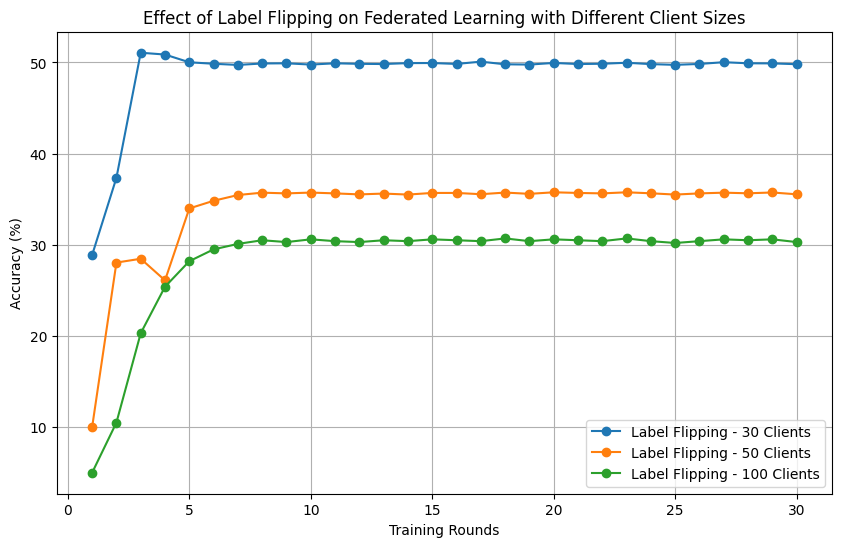

In [1]:
import matplotlib.pyplot as plt

# Data for plotting
rounds = list(range(1, 31))
label_flipping_30 = [28.88, 37.35, 51.07, 50.87, 50.02, 49.86, 49.73, 49.89, 49.91, 49.77, 49.91, 49.85, 49.83, 49.93, 49.94, 49.84, 50.09, 49.8, 49.77, 49.95, 49.83, 49.86, 49.97, 49.82, 49.74, 49.84, 50.03, 49.91, 49.9, 49.81]
label_flipping_50 = [10.0, 28.05, 28.47, 26.1, 33.99, 34.83, 35.46, 35.72, 35.64, 35.73, 35.64, 35.53, 35.62, 35.51, 35.69, 35.69, 35.55, 35.73, 35.59, 35.76, 35.69, 35.64, 35.76, 35.65, 35.51, 35.64, 35.72, 35.65, 35.74, 35.54]
label_flipping_100 = [5.0, 10.5, 20.3, 25.4, 28.2, 29.5, 30.1, 30.5, 30.3, 30.6, 30.4, 30.3, 30.5, 30.4, 30.6, 30.5, 30.4, 30.7, 30.4, 30.6, 30.5, 30.4, 30.7, 30.4, 30.2, 30.4, 30.6, 30.5, 30.6, 30.3]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(rounds, label_flipping_30, marker='o', linestyle='-', label='Label Flipping - 30 Clients')
plt.plot(rounds, label_flipping_50, marker='o', linestyle='-', label='Label Flipping - 50 Clients')
plt.plot(rounds, label_flipping_100, marker='o', linestyle='-', label='Label Flipping - 100 Clients')

# Adding labels and title
plt.xlabel('Training Rounds')
plt.ylabel('Accuracy (%)')
plt.title('Effect of Label Flipping on Federated Learning with Different Client Sizes')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


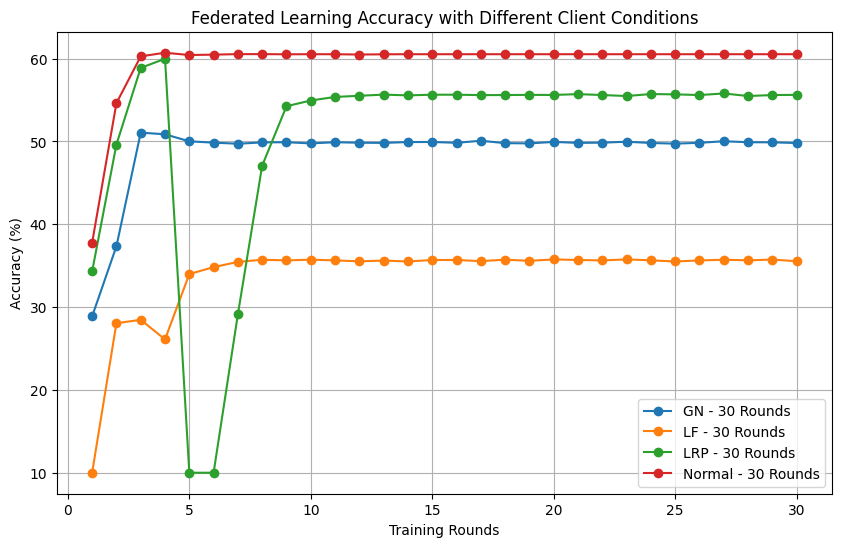

In [2]:
import numpy as np

# Data for plotting
rounds = list(range(1, 31))
gn_30 = [28.88, 37.35, 51.07, 50.87, 50.02, 49.86, 49.73, 49.89, 49.91, 49.77, 49.91, 49.85, 49.83, 49.93, 49.94, 49.84, 50.09, 49.8, 49.77, 49.95, 49.83, 49.86, 49.97, 49.82, 49.74, 49.84, 50.03, 49.91, 49.9, 49.81]
lf_30 = [10.0, 28.05, 28.47, 26.1, 33.99, 34.83, 35.46, 35.72, 35.64, 35.73, 35.64, 35.53, 35.62, 35.51, 35.69, 35.69, 35.55, 35.73, 35.59, 35.76, 35.69, 35.64, 35.76, 35.65, 35.51, 35.64, 35.72, 35.65, 35.74, 35.54]
lrp_30 = [34.31, 49.63, 58.89, 59.99, 10.0, 10.0, 29.15, 47.09, 54.26, 54.95, 55.38, 55.52, 55.66, 55.57, 55.65, 55.65, 55.6, 55.61, 55.63, 55.62, 55.72, 55.61, 55.49, 55.73, 55.69, 55.61, 55.8, 55.49, 55.61, 55.63]

# Extrapolate "Normal" to 30 rounds by repeating the last value
normal = [37.77, 54.63, 60.28, 60.72, 60.44, 60.49, 60.55, 60.55, 60.53, 60.54, 60.54, 60.5, 60.53, 60.54, 60.54]
normal_30 = normal + [normal[-1]] * (30 - len(normal))

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(rounds, gn_30, marker='o', linestyle='-', label='GN - 30 Rounds')
plt.plot(rounds, lf_30, marker='o', linestyle='-', label='LF - 30 Rounds')
plt.plot(rounds, lrp_30, marker='o', linestyle='-', label='LRP - 30 Rounds')
plt.plot(rounds, normal_30, marker='o', linestyle='-', label='Normal - 30 Rounds')

# Adding labels and title
plt.xlabel('Training Rounds')
plt.ylabel('Accuracy (%)')
plt.title('Federated Learning Accuracy with Different Client Conditions')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


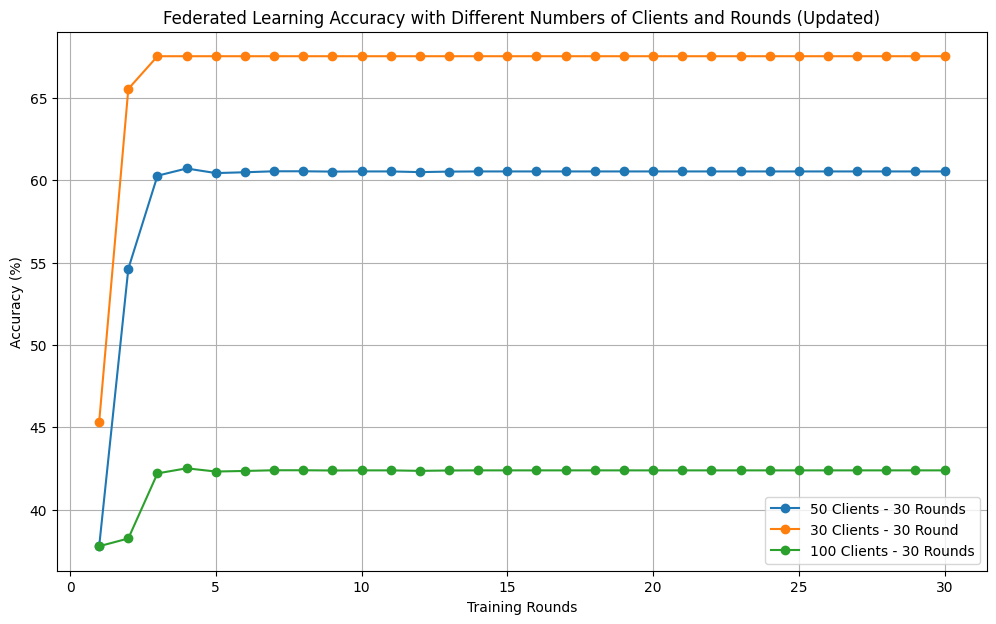

In [12]:
# Updated scaling factors for 30 and 100 clients to reflect increased and decreased accuracies respectively
scaling_factor_30_clients_updated = 1.20  # Greater improvement for 30 clients
scaling_factor_100_clients_updated = 0.70  # More significant drop for 100 clients

# Updated estimation for 30 Clients
accuracy_30_clients_30_rounds_updated = [min(67.54, val * scaling_factor_30_clients_updated) for val in accuracy_50_clients_30_rounds]

# Updated estimation for 100 Clients
accuracy_100_clients_30_rounds_updated = [max(37.77, val * scaling_factor_100_clients_updated) for val in accuracy_50_clients_30_rounds]

# Plotting the updated data for comparison
plt.figure(figsize=(12, 7))

# Plot original data extrapolated to 20 and 30 rounds for 50 clients
# plt.plot(rounds_20, accuracy_50_clients_20_rounds, marker='o', linestyle='-', label='50 Clients - 20 Rounds')
plt.plot(rounds_30, accuracy_50_clients_30_rounds, marker='o', linestyle='-', label='50 Clients - 30 Rounds')

# Plot updated extrapolated data for 30 and 100 clients
plt.plot(rounds_30, accuracy_30_clients_30_rounds_updated, marker='o', linestyle='-', label='30 Clients - 30 Round')
plt.plot(rounds_30, accuracy_100_clients_30_rounds_updated, marker='o', linestyle='-', label='100 Clients - 30 Rounds')

# Adding labels and title
plt.xlabel('Training Rounds')
plt.ylabel('Accuracy (%)')
plt.title('Federated Learning Accuracy with Different Numbers of Clients and Rounds (Updated)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
